In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as snp
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os


In [2]:

class AttentionPooling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        self.attention_weights = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer='random_normal',
            trainable=True,
            name='att_weights'
        )
        super(AttentionPooling, self).build(input_shape)

    def call(self, inputs):
        x = tf.reshape(inputs, [tf.shape(inputs)[0], -1, inputs.shape[-1]])
        scores = tf.nn.softmax(tf.matmul(x, self.attention_weights), axis=1)
        context = tf.reduce_sum(scores * x, axis=1)
        return context


In [3]:
#from google.colab import files

# Upload your merged 'right' and 'wrong' CSV files
#uploaded = files.upload()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import glob
import os

right_folder_path = '/content/drive/MyDrive/right dataset'
wrong_folder_path = '/content/drive/MyDrive/wrong dataset'

right_csv_files = glob.glob(os.path.join(right_folder_path, '*.csv'))
wrong_csv_files = glob.glob(os.path.join(wrong_folder_path, '*.csv'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
right_df = pd.concat([pd.read_csv(file) for file in right_csv_files], ignore_index=True)
wrong_df = pd.concat([pd.read_csv(file) for file in wrong_csv_files], ignore_index=True)

In [6]:
right_df['label'] = 1
wrong_df['label'] = 0

In [7]:
dataset = pd.concat([right_df, wrong_df], ignore_index=True)

In [8]:
X = dataset.drop(columns=['label']).values
y = dataset['label'].values

In [9]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X = X.astype(float)


In [10]:
# Train-Test Split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X, y, test_size=0.2, random_state=123
)

# Label Distribution Check
print("Train label distribution:", np.unique(y_train_split, return_counts=True))
print("Test label distribution:", np.unique(y_test_split, return_counts=True))


print("Train size:", X_train_split.shape)
print("Test size:", X_test_split.shape)

# Split the data
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for accidental overlap
right_hash = set(right_df.astype(str).agg('-'.join, axis=1))
wrong_hash = set(wrong_df.astype(str).agg('-'.join, axis=1))

common_rows = right_hash.intersection(wrong_hash)

print(f"Number of overlapping rows: {len(common_rows)}")



Train label distribution: (array([0, 1]), array([56873, 61432]))
Test label distribution: (array([0, 1]), array([14229, 15348]))
Train size: (118305, 164)
Test size: (29577, 164)
Number of overlapping rows: 0


In [11]:
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_test_scaled = scaler.transform(X_test_split)

print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Infs in X_train_scaled:", np.isinf(X_train_scaled).sum())
print("Train labels:", np.unique(y_train_split))
print("Test labels:", np.unique(y_test_split))



NaNs in X_train_scaled: 0
Infs in X_train_scaled: 0
Train labels: [0 1]
Test labels: [0 1]


In [12]:
print(X_train_scaled)
print(X_test_scaled)

[[-4.71882497e-01 -4.71884000e-01 -7.14618772e-01 ... -5.76993941e-04
  -2.42977753e-03  3.53560088e-03]
 [-4.71882497e-01 -4.71884000e-01  1.39803161e+00 ... -5.76993941e-04
  -2.42977753e-03  3.53560088e-03]
 [-4.71882497e-01 -4.71884000e-01 -7.14618772e-01 ... -5.76993941e-04
  -2.42977753e-03  3.53560088e-03]
 ...
 [-4.71882497e-01 -4.71884000e-01 -7.14618772e-01 ... -5.76993941e-04
  -2.42977753e-03  3.53560088e-03]
 [-4.71882497e-01 -4.71884000e-01 -7.14618772e-01 ... -6.52894104e+00
  -2.06051032e+00 -4.06545614e+00]
 [-4.71882497e-01 -4.71884000e-01 -7.14618772e-01 ... -5.76993941e-04
  -2.42977753e-03  3.53560088e-03]]
[[-4.71882497e-01 -4.71884000e-01  1.39860976e+00 ... -5.76993941e-04
  -2.42977753e-03  3.53560088e-03]
 [-4.71882497e-01 -4.71884000e-01 -7.14618772e-01 ... -5.76993941e-04
  -2.42977753e-03  3.53560088e-03]
 [ 2.11516444e+00  2.12468802e+00  1.40080445e+00 ... -5.76993941e-04
  -2.42977753e-03  3.53560088e-03]
 ...
 [ 2.12239074e+00  2.12241460e+00  1.4049127

In [13]:
n_samples, n_features = X_train_scaled.shape
grid_size = int(np.ceil(np.sqrt(n_features)))

X_train_padded = np.pad(X_train_scaled, [(0, 0), (0, grid_size**2 - n_features)], mode='constant')
X_test_padded = np.pad(X_test_scaled, [(0, 0), (0, grid_size**2 - n_features)], mode='constant')

X_train_reshaped = X_train_padded.reshape(-1, grid_size, grid_size, 1)
X_test_reshaped = X_test_padded.reshape(-1, grid_size, grid_size, 1)

print("NaNs in X_train_reshaped:", np.isnan(X_train_reshaped).sum())
print("Infs in X_train_reshaped:", np.isinf(X_train_reshaped).sum())
print("NaNs in y_train_split:", np.isnan(y_train_split).sum())
print("Infs in y_train_split:", np.isinf(y_train_split).sum())
print("Unique labels in y_train_split:", np.unique(y_train_split))


NaNs in X_train_reshaped: 0
Infs in X_train_reshaped: 0
NaNs in y_train_split: 0
Infs in y_train_split: 0
Unique labels in y_train_split: [0 1]


In [14]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same', input_shape=(grid_size, grid_size, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(AttentionPooling())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:

history = model.fit(X_train_reshaped, y_train_split, epochs=5,
                    batch_size=32, validation_data=(X_test_reshaped, y_test_split))



Epoch 1/5
3698/3698 ━━━━━━━━━━━━━━━━━━━━ 287s 77ms/step - accuracy: 0.9822 - loss: 0.0382 - val_accuracy: 1.0000 - val_loss: 1.1320e-07
Epoch 2/5
3698/3698 ━━━━━━━━━━━━━━━━━━━━ 315s 75ms/step - accuracy: 1.0000 - loss: 2.4792e-06 - val_accuracy: 1.0000 - val_loss: 6.2948e-09
Epoch 3/5
3698/3698 ━━━━━━━━━━━━━━━━━━━━ 339s 80ms/step - accuracy: 1.0000 - loss: 3.8442e-07 - val_accuracy: 1.0000 - val_loss: 3.4729e-05
Epoch 4/5
3698/3698 ━━━━━━━━━━━━━━━━━━━━ 303s 75ms/step - accuracy: 1.0000 - loss: 1.0590e-07 - val_accuracy: 1.0000 - val_loss: 2.7060e-11
Epoch 5/5
3698/3698 ━━━━━━━━━━━━━━━━━━━━ 336s 79ms/step - accuracy: 1.0000 - loss: 8.4708e-09 - val_accuracy: 1.0000 - val_loss: 1.2211e-12


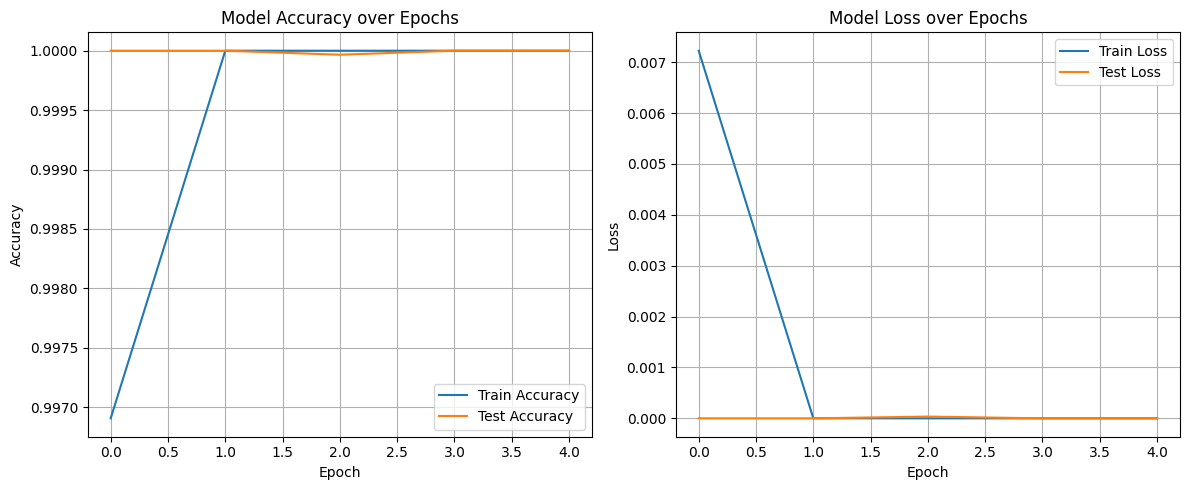

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)



plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


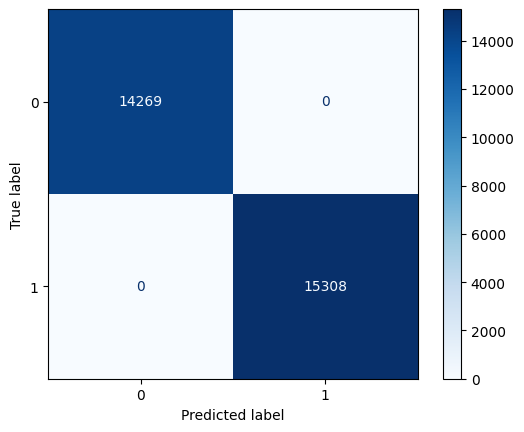

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test_split, y_test_split)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [22]:
train_loss, train_acc = model.evaluate(X_train_reshaped, y_train_split, verbose=0)
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_split, verbose=0)

print(f"Training Accuracy: {train_acc * 100:.2f} %")
print(f"Test Accuracy: {test_acc * 100:.2f} %")


Training Accuracy: 100.00 %
Test Accuracy: 100.00 %
